In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import math

# Load dataset

In [2]:
available_coins = ['ADA', 'BNB', 'BTC', 'DASH', 'ETH', 'LINK', 'LTC', 'XRP']
print("Available coins: ", available_coins)

Available coins:  ['ADA', 'BNB', 'BTC', 'DASH', 'ETH', 'LINK', 'LTC', 'XRP']


In [3]:
conc = None # "rsi", "macd", "macd_rsi"

def read_coin_data(coin_name: str, conc) -> pd.DataFrame:
    
    if conc == None:
        raw_data_path = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name ,f"{coin_name.lower()}_2019.csv")
        data_df = pd.read_csv(raw_data_path, index_col=False)
        return data_df
    
    elif (conc == "rsi") or (conc == "macd"):
        raw_data_path1 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name , f"{coin_name.lower()}_2019.csv")
        raw_data_path2 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_{conc}.csv")

        data_df1 = pd.read_csv(raw_data_path1, index_col=False)
        data_df2 = pd.read_csv(raw_data_path2, index_col=False)
        data_df2 = data_df2.drop('Time', axis=1)
        data_df2 = data_df2.rename(columns={"0": conc})
        
        concatenated = pd.concat([data_df1, data_df2], axis="columns")

        
    elif conc == "macd_rsi":      
        raw_data_path1 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name , f"{coin_name.lower()}_2019.csv")
        raw_data_path2 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_macd.csv")
        raw_data_path3 = join("io", "input", "data_raw", "Crypto_July_2019_2023", "4H_2019", coin_name, f"{coin_name.lower()}_4h_rsi.csv")
        
        data_df1 = pd.read_csv(raw_data_path1, index_col=False)
        data_df2 = pd.read_csv(raw_data_path2, index_col=False)
        data_df3 = pd.read_csv(raw_data_path3, index_col=False)
        
        data_df2 = data_df2.drop('Time', axis=1)
        data_df2 = data_df2.rename(columns={"0": "macd"})
        
        data_df3 = data_df3.drop('Time', axis=1)
        data_df3 = data_df3.rename(columns={"0": "rsi"})

        concatenated = pd.concat([data_df1, data_df2, data_df3], axis="columns")

      
        
    concatenated = concatenated.dropna(axis=0)
    concatenated = concatenated.reset_index()
    concatenated = concatenated.drop('index', axis=1)
    print(concatenated.head())

    return concatenated


# Feature engineering

## Time & date features

In [4]:
# Nikos Karantaglis = I have add column 'Hour'
def append_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    df['Hour'] = df['Date'].dt.hour
    return df

In [5]:
# Nikos Karantaglis = I have add sin(hour) and cosine(hour)
def create_trigonometric_columns(df) -> pd.DataFrame:
    # Create sine and cosine columns for Year, Month and Day
    df['Year_sin'] = df['Year'].apply(lambda x: math.sin(2*math.pi*x/2023))
    df['Year_cos'] = df['Year'].apply(lambda x: math.cos(2*math.pi*x/2023))
    df['Month_sin'] = df['Month'].apply(lambda x: math.sin(2*math.pi*x/12))
    df['Month_cos'] = df['Month'].apply(lambda x: math.cos(2*math.pi*x/12))
    df['Day_sin'] = df['Day'].apply(lambda x: math.sin(2*math.pi*x/31))
    df['Day_cos'] = df['Day'].apply(lambda x: math.cos(2*math.pi*x/31))
    df['Hour_sin'] = df['Hour'].apply(lambda x: math.sin(2*math.pi*x/24))
    df['Hour_cos'] = df['Hour'].apply(lambda x: math.cos(2*math.pi*x/24))
    df = df.drop(['Year'], axis=1)
    df = df.drop(['Month'], axis=1)
    df = df.drop(['Day'], axis=1)
    df = df.drop(['Week_of_Year'], axis=1)
    df = df.drop(['Hour'], axis=1)    
    return df

## Create target column

In [6]:
def create_target_variable(df: pd.DataFrame, forecast_lead: int = 1) -> pd.DataFrame:    
    target_column = "Close"
    features = list(df.columns.difference([target_column]))
    
    target = f"{target_column}_lead_{forecast_lead}"
    df[target] = df[target_column].shift(-forecast_lead)
    df = df.iloc[:-forecast_lead]
    # display("Target added to dataframe", df.shape, df[['Close', target]].head())
    return df

In [7]:
# Nikos Karantaglis = I have add some fetures like lags, moving averages, also Target have been defined.
def get_coins_data(coins: list, conc) -> pd.DataFrame:
    if conc == None:
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume"])
    elif (conc == "rsi") or (conc == "macd"):
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume", conc])
    elif conc == "macd_rsi":
        df = pd.DataFrame(columns=["Open", "High","Low", "Close", "Volume", "macd", "rsi"])
    
    for coin in coins:
        coin_df = read_coin_data(coin_name=coin, conc=conc)
        coin_df["Asset_id"] = coin
        coin_df = coin_df.rename(columns={"Time":"Date"})
        coin_df = append_date_features(df=coin_df)
        coin_df = create_trigonometric_columns(df=coin_df)
        coin_df = create_target_variable(df=coin_df, forecast_lead= 1)
        # Set date as index
        coin_df.set_index('Date', inplace=True)
        df = pd.concat([df, coin_df])
        
        
    one_hot = pd.get_dummies(df['Asset_id'])
    df = pd.concat([df, one_hot], axis=1)
#     df['Open_Close_diff'] = df['Open'] - df['Close']
#     df['High_Low_diff'] = df['High'] - df['Low']
    
#     df['Open_lag1'] = df['Open'].shift(1).fillna(df['Open'].median())
#     df['Open_lag2'] = df['Open'].shift(2).fillna(df['Open'].median())
#     df['Open_lag3'] = df['Open'].shift(3).fillna(df['Open'].median())
#     df['Open_lag4'] = df['Open'].shift(4).fillna(df['Open'].median())
    
#     df['Volume_lag1'] = df['Volume'].shift(1).fillna(df['Volume'].median())
#     df['Volume_lag2'] = df['Volume'].shift(2).fillna(df['Volume'].median())
#     df['Volume_lag3'] = df['Volume'].shift(3).fillna(df['Volume'].median())
#     df['Volume_lag4'] = df['Volume'].shift(4).fillna(df['Volume'].median())
    
#     df['Close_lag1'] = df['Close'].shift(1).fillna(df['Close'].median())
#     df['Close_lag2'] = df['Close'].shift(2).fillna(df['Close'].median())
#     df['Close_lag3'] = df['Close'].shift(3).fillna(df['Close'].median())
#     df['Close_lag4'] = df['Close'].shift(4).fillna(df['Close'].median())
    
#     df['Close_ma_1d'] = df.groupby('Asset_id')['Close'].rolling(6, min_periods=1).mean().reset_index(0, drop=True)
#     df['Close_ma_2d'] = df.groupby('Asset_id')['Close'].rolling(18, min_periods=1).mean().reset_index(0, drop=True)
#     df['Close_ma_3d'] = df.groupby('Asset_id')['Close'].rolling(42, min_periods=1).mean().reset_index(0, drop=True)
    
    df['Target'] = df['Close_lead_1']
     
    df = df.drop(['Close_lead_1'], axis=1)
    display("Consolidated dataframe shape",df.shape)
    return df

In [8]:
consolidated_df = get_coins_data(coins=available_coins, conc=conc)
consolidated_df.head()

'Consolidated dataframe shape'

(63976, 23)

,Open,High,Low,Close,Volume,Asset_id,Year_sin,Year_cos,Month_sin,Month_cos,...,Hour_cos,ADA,BNB,BTC,DASH,ETH,LINK,LTC,XRP,Target
2019-07-20 16:00:00,0.06222,0.06509,0.06203,0.06474,35347035.0,ADA,-0.012423,0.999923,-0.5,-0.866025,...,-0.5,1,0,0,0,0,0,0,0,0.06262
2019-07-20 20:00:00,0.06475,0.06484,0.06221,0.06262,17106974.9,ADA,-0.012423,0.999923,-0.5,-0.866025,...,0.5,1,0,0,0,0,0,0,0,0.06147
2019-07-21 00:00:00,0.06262,0.06400,0.06136,0.06147,15707034.1,ADA,-0.012423,0.999923,-0.5,-0.866025,...,1.0,1,0,0,0,0,0,0,0,0.06237
2019-07-21 04:00:00,0.06145,0.06253,0.06136,0.06237,7069070.1,ADA,-0.012423,0.999923,-0.5,-0.866025,...,0.5,1,0,0,0,0,0,0,0,0.06179
2019-07-21 08:00:00,0.06230,0.06315,0.06136,0.06179,10194081.5,ADA,-0.012423,0.999923,-0.5,-0.866025,...,-0.5,1,0,0,0,0,0,0,0,0.06048


In [9]:
consolidated_df.loc['2021-08-29 12:00:00', :]	

,Open,High,Low,Close,Volume,Asset_id,Year_sin,Year_cos,Month_sin,Month_cos,...,Hour_cos,ADA,BNB,BTC,DASH,ETH,LINK,LTC,XRP,Target
2021-08-29 12:00:00,2.8680,2.9200,2.8340,2.8640,5.516160e+07,ADA,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,1,0,0,0,0,0,0,0,2.894
2021-08-29 12:00:00,484.5000,487.5000,480.0000,483.3000,1.278030e+05,BNB,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,1,0,0,0,0,0,0,482.100
2021-08-29 12:00:00,48159.9800,48561.4600,48105.0300,48474.9500,4.372836e+03,BTC,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,1,0,0,0,0,0,48799.270
2021-08-29 12:00:00,237.3000,239.0000,230.1000,231.7000,1.889266e+04,DASH,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,0,1,0,0,0,0,226.600
2021-08-29 12:00:00,3181.8300,3206.8300,3165.5700,3186.9900,4.118715e+04,ETH,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,0,0,1,0,0,0,3220.230
2021-08-29 12:00:00,25.4800,25.7800,25.1400,25.3800,4.821117e+05,LINK,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,0,0,0,1,0,0,25.690
2021-08-29 12:00:00,175.9000,177.6000,173.1000,174.5000,7.768099e+04,LTC,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,0,0,0,0,1,0,175.100
2021-08-29 12:00:00,1.1354,1.1458,1.1192,1.1322,5.166905e+07,XRP,-0.006212,0.999981,-0.866025,-0.5,...,-1.0,0,0,0,0,0,0,0,1,1.155


# Split dataset

In [10]:
def split_train_valid_test(data: pd.DataFrame):    
    # Split the data into training and testing sets
    split_date_1 = datetime(2022, 1, 1)
    split_date_2 = datetime(2022, 12, 1)
    train_data = data.loc[data.index < split_date_1]
    valid_data = data.loc[(split_date_1<= data.index) & (data.index <= split_date_2)]
    test_data = data.loc[data.index > split_date_2]
    
    print("Train set fraction:", round((len(train_data) / len(data)), 2),'%', "- train shape -> ", train_data.shape)
    print("Valid set fraction:", round((len(valid_data) / len(data)), 2),'%', "- valid shape -> ", valid_data.shape)
    print("Test set fraction:", round((len(test_data) / len(data)), 2),'%', "- test shape -> ", test_data.shape)
    return train_data, valid_data, test_data

In [11]:
train_data, valid_data, test_data = split_train_valid_test(data=consolidated_df)

Train set fraction: 0.67 % - train shape ->  (42960, 23)
Valid set fraction: 0.25 % - valid shape ->  (16040, 23)
Test set fraction: 0.08 % - test shape ->  (4976, 23)


In [12]:
output_path = join("io", "input", "base_data")
train_data.to_csv(join(output_path, "train.csv"))
valid_data.to_csv(join(output_path, "valid.csv"))
test_data.to_csv(join(output_path, "test.csv"))
print("Datasets saved!")

Datasets saved!


Nikos Karantaglis: Plot every time-series of Close column for review purposes.

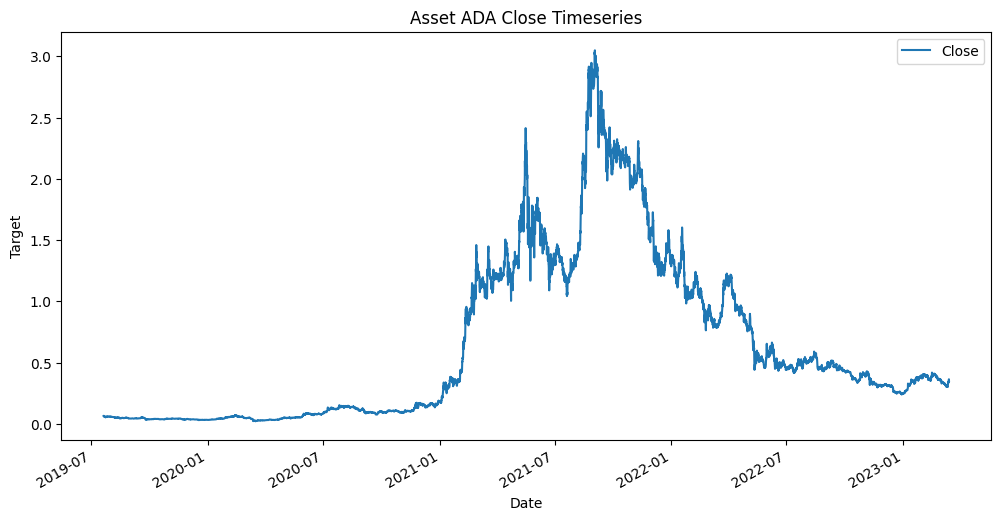

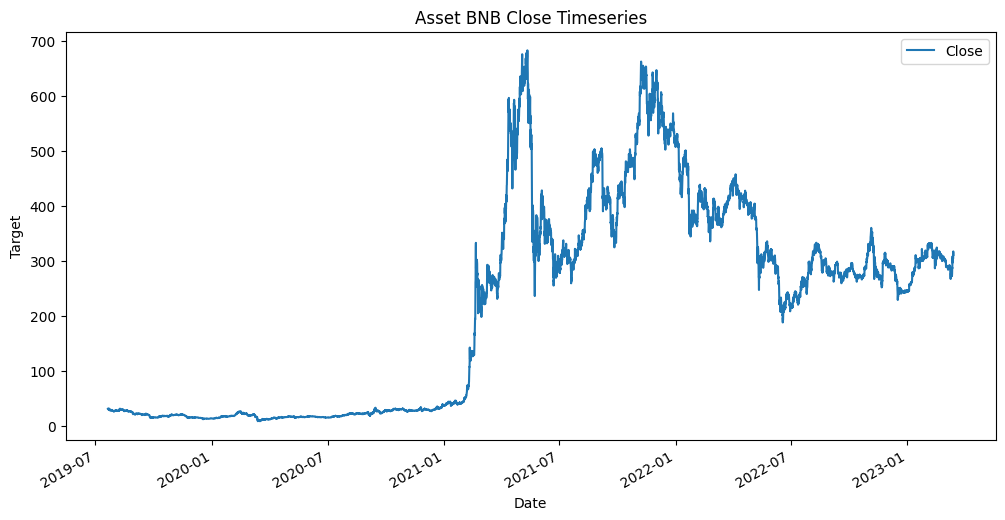

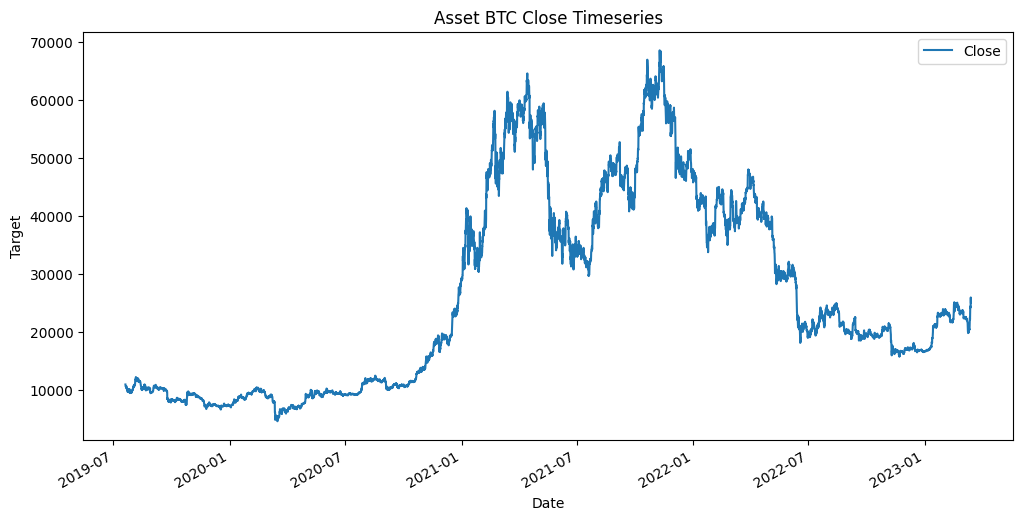

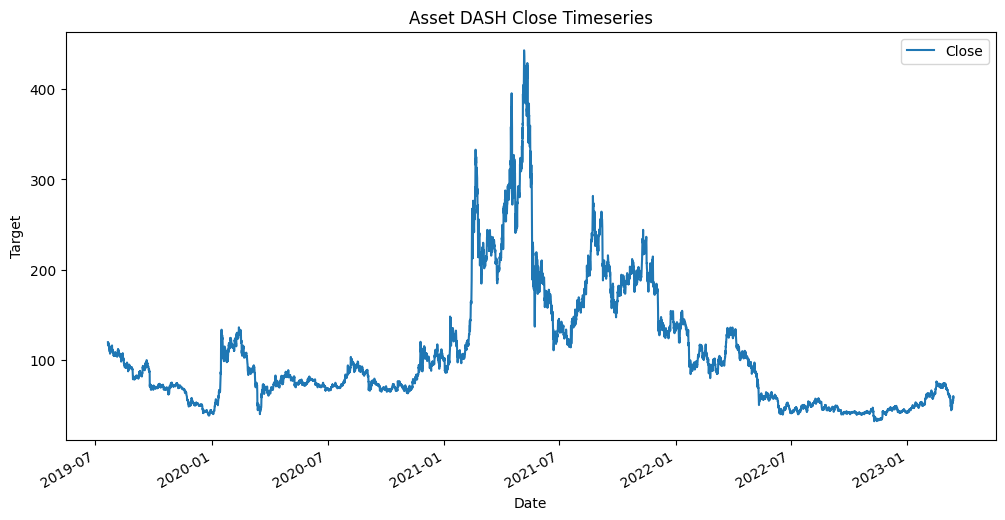

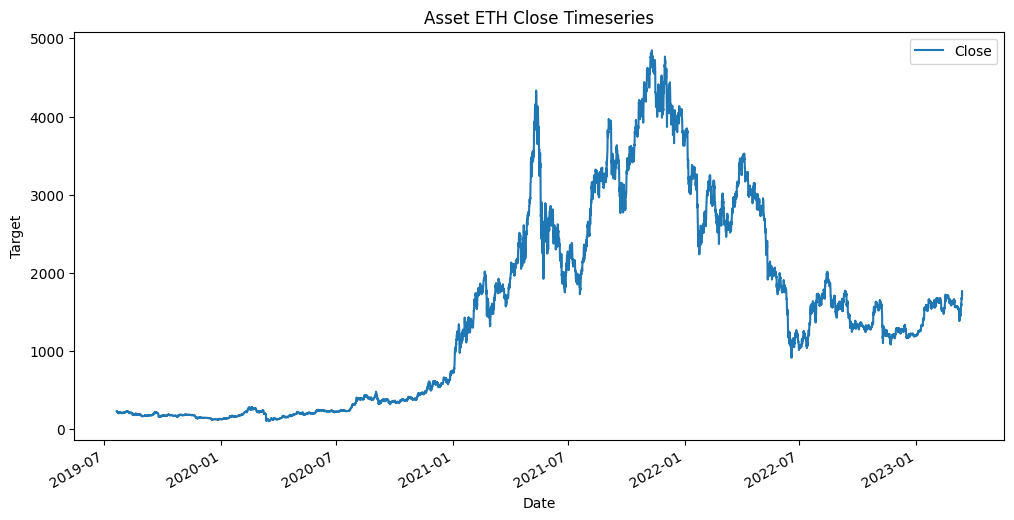

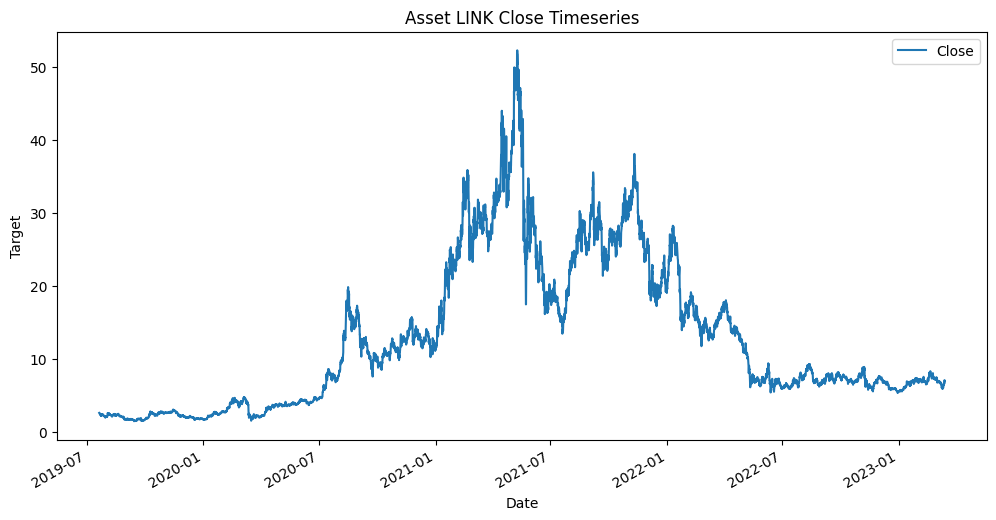

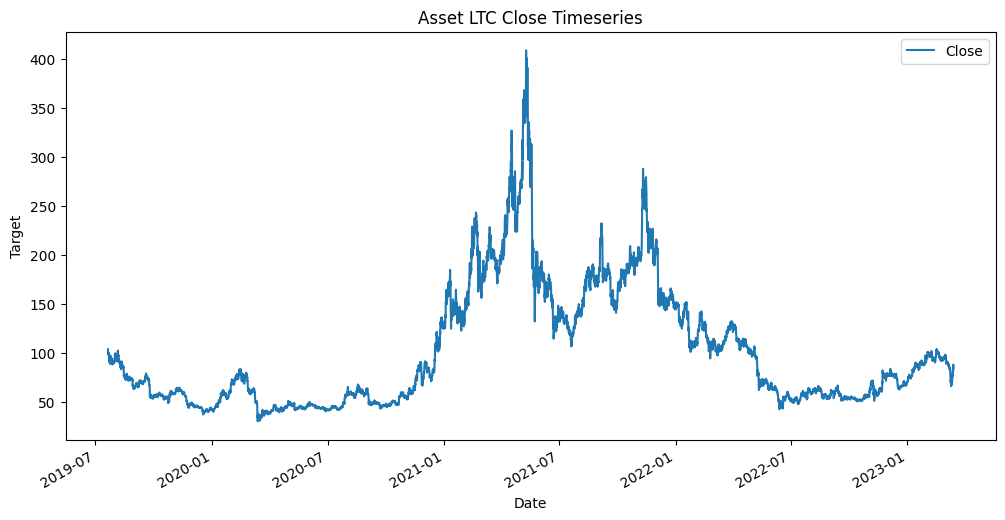

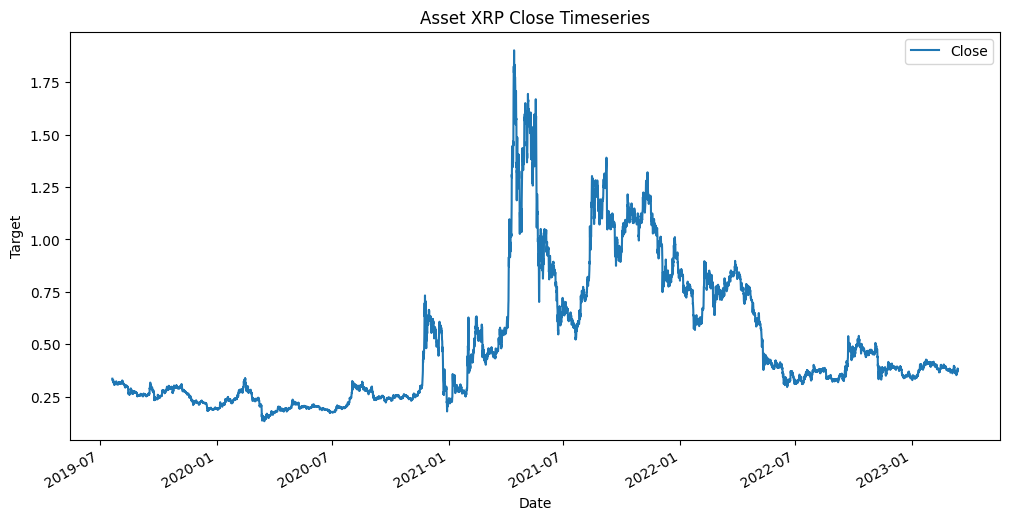

In [13]:
df=consolidated_df
import pandas as pd
import matplotlib.pyplot as plt

# assume your dataframe is called df and has columns 'Asset_id' and 'Close'
grouped = df.groupby('Asset_id')

for asset_id, group in grouped:
    # create a new figure for each plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # plot the timeseries for this asset_id
    group.plot(y='Close', ax=ax)
    
    # set title and axis labels
    ax.set_title(f"Asset {asset_id} Close Timeseries")
    ax.set_xlabel('Date')
    ax.set_ylabel('Target')
    
    # show the plot
    plt.show()